# Notebook for analysing results of the naming game, matrices visualizations

This notebook can be used for generating videos of all the naming matrices during training for a specific seed. A video of the evolution of the naming matrices will be stored in the experiment's directory

In [1]:
import os
import random
import tempfile
from copy import deepcopy
from datetime import datetime

import click
import imgc_marl.envs.population as population
import numpy as np
import yaml
from imgc_marl.callbacks import (
    PopGoalLinesCallback,
    PopGoalLinesCommunicationCallback,
    PopGoalLinesNamingCallback,
    PopGoalLinesNamingCallback1Matrix,
)
from imgc_marl.evaluation import (
    communication_custom_eval_function,
    custom_eval_function,
)
from imgc_marl.models.basic_communication import BasicCommunicationNetwork
from imgc_marl.models.full_naming_game import FullNamingNetwork
from imgc_marl.models.full_naming_game_single_matrix import FullNamingNetwork1Matrix
from imgc_marl.policies.basic_communication import BasicCommunicationTrainer
from imgc_marl.policies.full_naming_game import FullNamingTrainer
from imgc_marl.policies.full_naming_game_single_matrix import FullNamingTrainer1Matrix
from imgc_marl.utils import keep_relevant_results
from ray.rllib.agents.ppo import DEFAULT_CONFIG, PPOTrainer
from ray.rllib.models import ModelCatalog
from ray.rllib.policy.policy import PolicySpec
from ray.tune.logger import UnifiedLogger, pretty_print
import torch
import matplotlib.pyplot as plt
import moviepy

* Select correct configuration file 
* Select environment (3 or 6 landmarks)
* Select the experiment you want to evaluate

In [2]:
!ls 2_agents/cooperative/modified_reward/6_landmarks/naming_game/2_matrix


2022-10-15_20-21-051i6ubnd9  train-152633_0.slurm.err  train-152633_2.slurm.out
2022-10-15_20-21-055x1s5ecg  train-152633_0.slurm.out  train-152633_3.slurm.err
2022-10-15_20-21-05l2jrttu4  train-152633_1.slurm.err  train-152633_3.slurm.out
2022-10-15_20-21-05n2r125tc  train-152633_1.slurm.out  train-152633_4.slurm.err
2022-10-15_20-21-05zvlbcbhk  train-152633_2.slurm.err  train-152633_4.slurm.out


In [2]:
!ls 2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30


2022-10-27_19-14-40v1v3_6dl  stdout.txt		       train-493234_2.slurm.out
2022-10-27_19-19-56_8ve71_y  train-493234_0.slurm.err  train-493234_3.slurm.err
2022-10-27_19-21-22pozgzx7i  train-493234_0.slurm.out  train-493234_3.slurm.out
2022-10-27_19-24-53kh4dr43g  train-493234_1.slurm.err  train-493234_4.slurm.err
2022-10-27_19-24-53qlfxv7fz  train-493234_1.slurm.out  train-493234_4.slurm.out
stderr.txt		     train-493234_2.slurm.err


In [45]:
!ls 2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b


2022-10-25_22-07-33e3kaf119  train-427643_0.slurm.err  train-427643_2.slurm.out
2022-10-25_22-07-3606x7jyz3  train-427643_0.slurm.out  train-427643_3.slurm.err
2022-10-25_22-07-369e50deqs  train-427643_1.slurm.err  train-427643_3.slurm.out
2022-10-25_22-07-36nrhqi86q  train-427643_1.slurm.out  train-427643_4.slurm.err
2022-10-25_22-07-44fppth2yq  train-427643_2.slurm.err  train-427643_4.slurm.out


In [9]:
from imgc_marl.envs.population import PopGoalLinesEnv, PopLargeGoalLinesEnv

# 3 landmarks
#config_file = "goal_lines_naming.yml"
config_file="goal_lines_2agents_naming_game_all_modified.yml"
environment = PopGoalLinesEnv

# 6 landmarks
#config_file = "large_goal_lines_2agents_naming_game_all_modified.yml"
#environment = PopLargeGoalLinesEnv


# directory of the checkpoints you want to evaluate
checkpoints_dir = "2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl"

In [10]:
with open(f"../scripts/configs/{config_file}", "r") as f:
    user_config = yaml.safe_load(f)
# General settings of the algorithm
config = deepcopy(DEFAULT_CONFIG)
config["num_workers"] = 0
config["framework"] = "torch"
use_communication = user_config.get("communication", False)

config["horizon"] = 300
config["rollout_fragment_length"] = config["horizon"]
config["env_config"] = user_config["env_config"]
config["train_batch_size"] = 60_000
config["sgd_minibatch_size"] = 10_000
config["lambda"] = 0.9
config["lr"] = 0.0003


nb_msg= 30

def policy_mapping_fn(agent_id):
    return agent_id


config["multiagent"] = {
    "policies": {
        f"agent_{i}": PolicySpec(
            policy_class=None, observation_space=None, action_space=None
        )
        for i in range(config["env_config"]["population_size"])
    },
    "policy_mapping_fn": policy_mapping_fn,
}

train_env = environment

ModelCatalog.register_custom_model("FullNamingNetwork1Matrix", FullNamingNetwork1Matrix)
number_of_goals = environment(config["env_config"]).goal_space_dim
config["model"] = {
    "custom_model": "FullNamingNetwork1Matrix",
    "custom_model_config": {
        "number_of_goals": number_of_goals,
        "train_matrix": user_config.get("train_matrix", False),
        "nb_msg":nb_msg,
    },
}
trainer = FullNamingTrainer1Matrix(
    config=config,
    env=train_env,
)

2022-10-28 10:33:40,515	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-28 10:33:40,516	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-28 10:33:40,516	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-28 10:33:40,517	WARNING multi_agent_env.py:193 -- action_space_sample() has not been implemented
2022-10-28 10:33:40,518	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-28 10:33:40,524	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-10-28 10:33:40,540	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


# Inspecting matrices through time

checkpoint-10


2022-10-28 10:34:00,803	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000010/checkpoint-10
2022-10-28 10:34:00,804	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 454.62507367134094, '_episodes_total': 2793}
2022-10-28 10:34:01,083	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000020/checkpoint-20
2022-10-28 10:34:01,083	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 913.6632552146912, '_episodes_total': 8613}


checkpoint-20


2022-10-28 10:34:01,352	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000030/checkpoint-30
2022-10-28 10:34:01,352	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1369.158375263214, '_episodes_total': 19069}


checkpoint-30


2022-10-28 10:34:01,556	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000040/checkpoint-40
2022-10-28 10:34:01,560	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 1841.3229908943176, '_episodes_total': 32017}


checkpoint-40


2022-10-28 10:34:01,828	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000050/checkpoint-50
2022-10-28 10:34:01,829	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2314.47483587265, '_episodes_total': 45309}


checkpoint-50


2022-10-28 10:34:02,266	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000060/checkpoint-60
2022-10-28 10:34:02,267	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 2807.906049489975, '_episodes_total': 58439}


checkpoint-60


2022-10-28 10:34:02,536	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000070/checkpoint-70
2022-10-28 10:34:02,537	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 3412.6584622859955, '_episodes_total': 71900}


checkpoint-70


2022-10-28 10:34:02,806	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000080/checkpoint-80
2022-10-28 10:34:02,806	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 3961.137195110321, '_episodes_total': 85498}


checkpoint-80


2022-10-28 10:34:03,070	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000090/checkpoint-90
2022-10-28 10:34:03,071	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 4471.144795656204, '_episodes_total': 98847}


checkpoint-90


2022-10-28 10:34:03,347	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000100/checkpoint-100
2022-10-28 10:34:03,347	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5057.337912321091, '_episodes_total': 112016}


checkpoint-100


2022-10-28 10:34:03,606	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000110/checkpoint-110
2022-10-28 10:34:03,607	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 5589.631548166275, '_episodes_total': 125205}


checkpoint-110


2022-10-28 10:34:03,866	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000120/checkpoint-120
2022-10-28 10:34:03,868	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 6111.158798933029, '_episodes_total': 138482}


checkpoint-120


2022-10-28 10:34:04,137	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000130/checkpoint-130
2022-10-28 10:34:04,140	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 6651.238924026489, '_episodes_total': 152061}


checkpoint-130


2022-10-28 10:34:04,409	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000140/checkpoint-140
2022-10-28 10:34:04,410	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 7163.3968098163605, '_episodes_total': 165401}


checkpoint-140


2022-10-28 10:34:04,674	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000150/checkpoint-150
2022-10-28 10:34:04,674	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 7768.003048419952, '_episodes_total': 178635}


checkpoint-150


2022-10-28 10:34:04,880	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000160/checkpoint-160
2022-10-28 10:34:04,887	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 8329.253116369247, '_episodes_total': 191975}


checkpoint-160


2022-10-28 10:34:05,154	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000170/checkpoint-170
2022-10-28 10:34:05,154	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 8852.435687065125, '_episodes_total': 205202}


checkpoint-170


2022-10-28 10:34:05,426	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000180/checkpoint-180
2022-10-28 10:34:05,427	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 9403.699460983276, '_episodes_total': 218651}


checkpoint-180


2022-10-28 10:34:05,633	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000190/checkpoint-190
2022-10-28 10:34:05,634	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 9920.983267784119, '_episodes_total': 232088}


checkpoint-190


2022-10-28 10:34:05,901	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000200/checkpoint-200
2022-10-28 10:34:05,902	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 10446.013216733932, '_episodes_total': 245656}


checkpoint-200


2022-10-28 10:34:06,277	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000210/checkpoint-210
2022-10-28 10:34:06,278	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 210, '_timesteps_total': None, '_time_total': 11038.544260501862, '_episodes_total': 259032}


checkpoint-210
checkpoint-220


2022-10-28 10:34:06,540	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000220/checkpoint-220
2022-10-28 10:34:06,540	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 11561.213726043701, '_episodes_total': 272567}
2022-10-28 10:34:06,743	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000230/checkpoint-230
2022-10-28 10:34:06,744	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 230, '_timesteps_total': None, '_time_total': 12086.260548591614, '_episodes_total': 286271}


checkpoint-230


2022-10-28 10:34:07,007	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000240/checkpoint-240
2022-10-28 10:34:07,007	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 12609.811352014542, '_episodes_total': 299849}


checkpoint-240


2022-10-28 10:34:07,268	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000250/checkpoint-250
2022-10-28 10:34:07,270	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 250, '_timesteps_total': None, '_time_total': 13106.82937836647, '_episodes_total': 313616}


checkpoint-250


2022-10-28 10:34:07,520	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000260/checkpoint-260
2022-10-28 10:34:07,522	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 13656.268040180206, '_episodes_total': 327135}


checkpoint-260


2022-10-28 10:34:07,728	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000270/checkpoint-270
2022-10-28 10:34:07,728	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 270, '_timesteps_total': None, '_time_total': 14221.347922801971, '_episodes_total': 340775}


checkpoint-270


2022-10-28 10:34:07,997	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000280/checkpoint-280
2022-10-28 10:34:07,997	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 14763.553443193436, '_episodes_total': 354508}


checkpoint-280


2022-10-28 10:34:08,263	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000290/checkpoint-290
2022-10-28 10:34:08,264	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 290, '_timesteps_total': None, '_time_total': 15322.773516893387, '_episodes_total': 368522}


checkpoint-290


2022-10-28 10:34:08,521	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000300/checkpoint-300
2022-10-28 10:34:08,523	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 15838.688460588455, '_episodes_total': 382169}


checkpoint-300


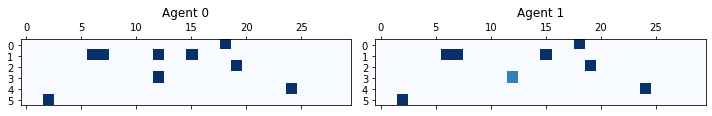

In [11]:
imgs = []
for checkpoint_dir in sorted(os.listdir(checkpoints_dir)):
    if os.path.isdir(os.path.join(checkpoints_dir, checkpoint_dir)):
        checkpoint_file = sorted(
            os.listdir(os.path.join(checkpoints_dir, checkpoint_dir))
        )[1]
        print(checkpoint_file)
        trainer.restore(os.path.join(checkpoints_dir, checkpoint_dir, checkpoint_file))
        agent_0 = trainer.get_policy("agent_0").model
        agent_1 = trainer.get_policy("agent_1").model
        with torch.no_grad():
            agent_0_matrix = agent_0._matrix.numpy()
            agent_1_matrix = agent_1._matrix.numpy()

            # Generate images
            for j, matrix in enumerate((agent_0_matrix, agent_1_matrix)):
                if j == 0:
                    fig = plt.figure(num=1, clear=True, figsize=(10, 10))
                    ax = fig.add_subplot(121)
                    ax.set_title("Agent 0")
                elif j == 1:
                    ax = fig.add_subplot(122)
                    ax.set_title("Agent 1")
                ax.matshow(matrix, cmap=plt.cm.Blues)
                for x in range(nb_msg):
                    for y in range(number_of_goals):
                        c = matrix[y, x]
                        #ax.text(x, y, str(round(c, 3)), va="center", ha="center")
                if j == 1:
                    plt.tight_layout()
                    canvas = fig.figure.canvas
                    canvas.draw()
                    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                    img = data.reshape(canvas.get_width_height()[::-1] + (3,))
                    imgs.append(img)
                    

In [12]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython.display import HTML, display, clear_output

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

Failed to create secure directory (/pulse): Permission denied
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
Failed to create secure directory (/pulse): Permission denied
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func

In [13]:
with VideoWriter("out.mp4", 2) as vid:
          for i in range(len(imgs)):
            im = imgs[i]
            
            #plt.imshow(im)
            #plt.show()
            vid.add(im)
          vid.show()